# Quantum Maze Solver

# Import

In [1]:
from maze.maze import Graph
from maze.maze_solver import BFSSolver, QuantumMazeSolver
from maze.maze_generator import PrimGenerator
from maze.maze_circuit import QuantumMazeCircuit
from collections import Counter


# Graph

## Graph generation

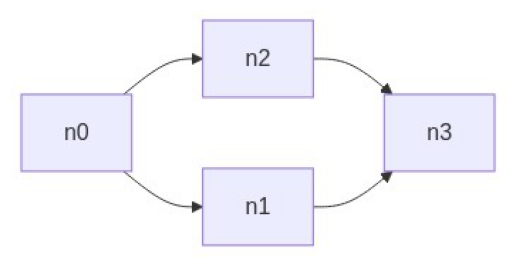

In [2]:
edges = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 3),
]
graph = Graph.from_edges(edges, start = 0, end = 3, bidirectional = False)
graph.show()


## Quantum Maze Circuit

MG 0
MG 1
MG 2


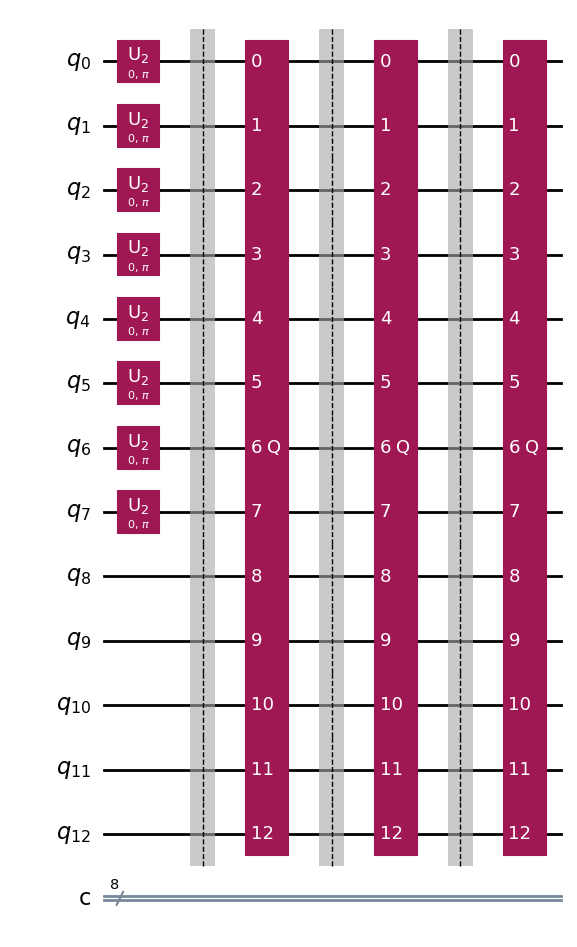

In [3]:
qc = QuantumMazeCircuit(graph, turn_back_check=True) # custom max_path_length can be set
qc.decompose(reps = 1).draw('mpl')

## Maze Solver

### Quantum

[0 -> 1 -> 3] : 1759
[0 -> 2 -> 3] : 1648
[3 -> 1 -> 0] : 39
[3 -> 1 -> 2 -> 0] : 39
[0 -> 3 -> 1] : 38
[1] : 38
[1 -> 3] : 38
[3 -> 2] : 37
[1 -> 2 -> 3 -> 0] : 37
[2 -> 0] : 37
[3 -> 2] : 36
[0 -> 1] : 36
[2 -> 0 -> 3] : 36
[3 -> 1 -> 2] : 36
[3 -> 1] : 36
[1] : 35
[3 -> 0] : 35
[2 -> 1] : 35
[0] : 35
[0 -> 2 -> 3] : 35
[2 -> 1 -> 3] : 35
[3 -> 0 -> 2] : 35
[1] : 34
[3 -> 1] : 34
[2 -> 1 -> 0] : 34
[0] : 34
[0 -> 1] : 34
[3] : 33
[1 -> 3 -> 2 -> 0] : 33
[2 -> 1] : 33
[0 -> 1] : 33
[1 -> 2 -> 0 -> 3] : 33
[2 -> 0 -> 1 -> 3] : 33
[2] : 33
[3 -> 2] : 33
[3 -> 2 -> 0] : 33
[3 -> 1] : 33
[0 -> 3] : 32
[3] : 32
[2 -> 0 -> 1] : 32
[0 -> 1] : 32
[1] : 32
[2 -> 1] : 32
[3 -> 2] : 32
[2 -> 0 -> 3] : 32
[1 -> 0] : 32
[2 -> 1 -> 0] : 31
[0 -> 1 -> 3 -> 2] : 31
[0] : 31
[2 -> 3] : 31
[2] : 31
[3 -> 2 -> 0] : 31
[1 -> 2 -> 3] : 30
[0 -> 1] : 30
[3 -> 0 -> 1] : 30
[0 -> 1 -> 2] : 30
[2 -> 1] : 30
[2 -> 3 -> 0 -> 1] : 30
[3 -> 2 -> 1 -> 0] : 30
[1 -> 2] : 30
[2 -> 0 -> 1] : 30
[3] : 30
[3 -> 0 -> 2]

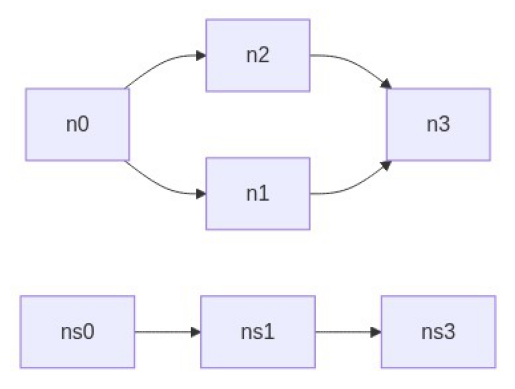

In [4]:
quantum_solver = QuantumMazeSolver()
result = quantum_solver.run(qc, shots=10000)
ordered_solution_with_frequency = sorted(Counter(result).items(), key=lambda x: -x[1])
[print(k.remove_cycles(), ':', v) for k, v in ordered_solution_with_frequency]
most_frequent_solution_path = ordered_solution_with_frequency[0][0].remove_cycles()
graph.show(most_frequent_solution_path)

### Classical

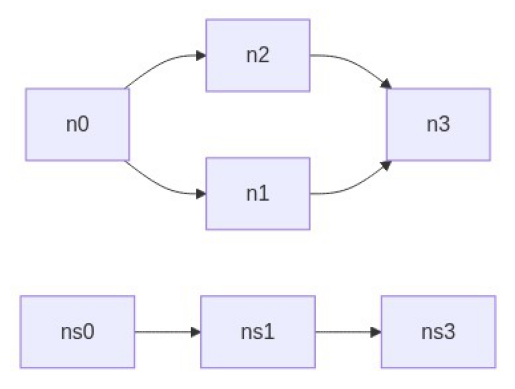

In [5]:
classical_solver = BFSSolver()
graph.show(classical_solver.solve(graph))

# Maze

## Maze Generation

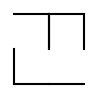

In [6]:
maze_generator = PrimGenerator()
maze = maze_generator.generate_maze(2, 2, (0, 0), (1, 1))
maze.show()

## Quantum Maze Circuit

MG 0
MG 1
MG 2


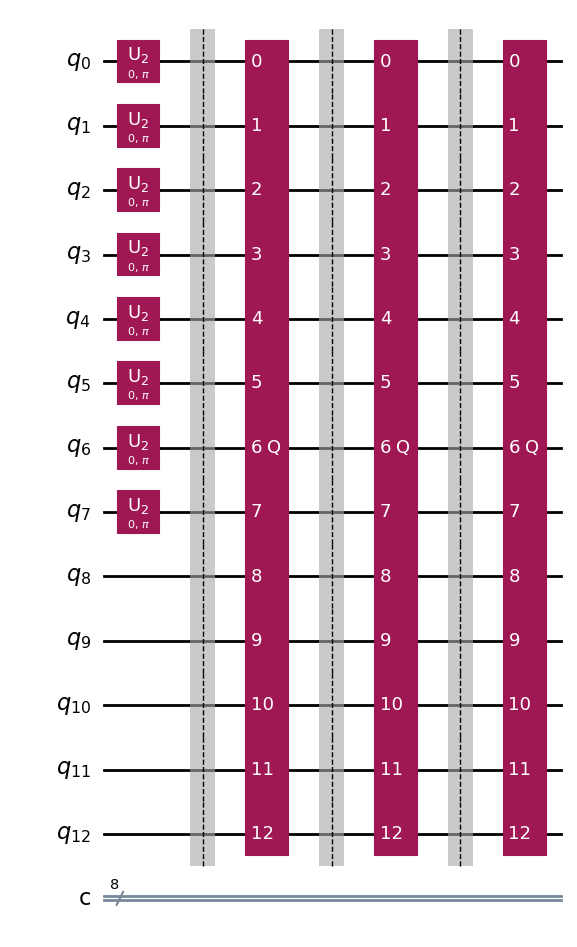

In [7]:
qc = QuantumMazeCircuit(maze, turn_back_check=True) # custom max_path_length can be set
qc.decompose(reps = 1).draw('mpl')

## Maze Solver

### Quantum

[0 -> 2 -> 3] : 1851
[1 -> 3 -> 2] : 48
[3 -> 2] : 48
[3 -> 1] : 47
[2 -> 3 -> 1] : 45
[1 -> 0 -> 3 -> 2] : 45
[0 -> 2] : 44
[1 -> 0] : 43
[3 -> 0] : 43
[0] : 42
[0 -> 1] : 42
[1 -> 3] : 42
[0 -> 2] : 42
[2 -> 1 -> 3] : 41
[3 -> 0] : 41
[0] : 41
[1 -> 2] : 40
[3] : 40
[3 -> 1] : 40
[1 -> 2 -> 3 -> 0] : 40
[0 -> 1] : 40
[1 -> 2 -> 3] : 40
[0 -> 1] : 39
[0 -> 1 -> 3 -> 2] : 39
[1 -> 0] : 39
[3 -> 1] : 39
[2 -> 3] : 39
[3 -> 2 -> 0] : 39
[2 -> 1] : 39
[3 -> 1 -> 0] : 39
[0 -> 1] : 39
[1 -> 3 -> 2] : 39
[3 -> 2] : 39
[3 -> 0 -> 2] : 38
[0 -> 3 -> 2] : 38
[3 -> 2] : 38
[0 -> 1 -> 2 -> 3] : 38
[2] : 38
[2 -> 3 -> 0] : 38
[2 -> 3] : 38
[3 -> 0 -> 2 -> 1] : 38
[0 -> 2] : 38
[1 -> 2 -> 3] : 38
[3 -> 2] : 37
[2 -> 0] : 37
[3 -> 0] : 37
[1 -> 3] : 37
[2] : 37
[0 -> 2 -> 1] : 37
[0 -> 3 -> 1] : 37
[0 -> 3 -> 2] : 37
[2 -> 0 -> 1] : 37
[0 -> 3] : 37
[1 -> 2] : 36
[0 -> 2 -> 1] : 36
[0] : 36
[1] : 36
[0 -> 3 -> 1 -> 2] : 36
[3 -> 0] : 36
[1 -> 0] : 36
[1 -> 0 -> 3] : 36
[0 -> 3] : 36
[2 -> 3 -> 0] :

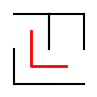

In [8]:
quantum_solver = QuantumMazeSolver()
result = quantum_solver.run(qc, shots=10000)
ordered_solution_with_frequency = sorted(Counter(result).items(), key=lambda x: -x[1])
[print(k.remove_cycles(), ':', v) for k, v in ordered_solution_with_frequency]
most_frequent_solution_path = ordered_solution_with_frequency[0][0].remove_cycles()
maze.show(most_frequent_solution_path)

### Classical

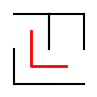

In [9]:
classical_solver = BFSSolver()
maze.show(classical_solver.solve(maze))